In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pycaret.time_series import *

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


data/petr_brent.csv
data/price.csv
data/per-capita-energy-use.csv
data/oil-share-energy.csv
data/fossil-fuel-primary-energy.csv
data/fossil-fuel-consumption-by-type.csv
data/anomalyze_df.csv
data/petr_brent_.csv
data/oil-production-by-country.csv
data/change-energy-consumption.csv
data/share-electricity-fossil-fuels.csv


In [59]:
# data = pd.read_csv("data/petr_brent.csv")

data = pd.read_csv("data/anomalyze_df.csv")[["date", "observed_clean"]]
data.rename(columns={"date": "DATE", "observed_clean": "VALUE (US$)"}, inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8562 entries, 0 to 8561
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         8562 non-null   object 
 1   VALUE (US$)  8562 non-null   float64
dtypes: float64(1), object(1)
memory usage: 133.9+ KB


In [60]:
data.index = pd.to_datetime(data["DATE"])
start = data.index[0].date()
end = data.index[len(data) - 1].date()
new_dates = pd.date_range(start=start, end=end, freq="D")
data = data.reindex(new_dates)
data = data.rename_axis("DATE")
data["VALUE (US$)"] = data["VALUE (US$)"].interpolate().bfill()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8562 entries, 2001-01-01 to 2024-06-10
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         8562 non-null   object 
 1   VALUE (US$)  8562 non-null   float64
dtypes: float64(1), object(1)
memory usage: 200.7+ KB


In [61]:
# data.drop(["DATE", "CODE", "RAW DATE"], axis=1, inplace=True)
data.drop(["DATE"], axis=1, inplace=True)
data.head()


VALUE (US$)
DATE                   
2001-01-01        23.43
2001-01-02        23.43
2001-01-03        23.44
2001-01-04        24.57
2001-01-05        24.77

<Axes: title={'center': 'Preço Petróleo tipo Brent'}, xlabel='DATE'>

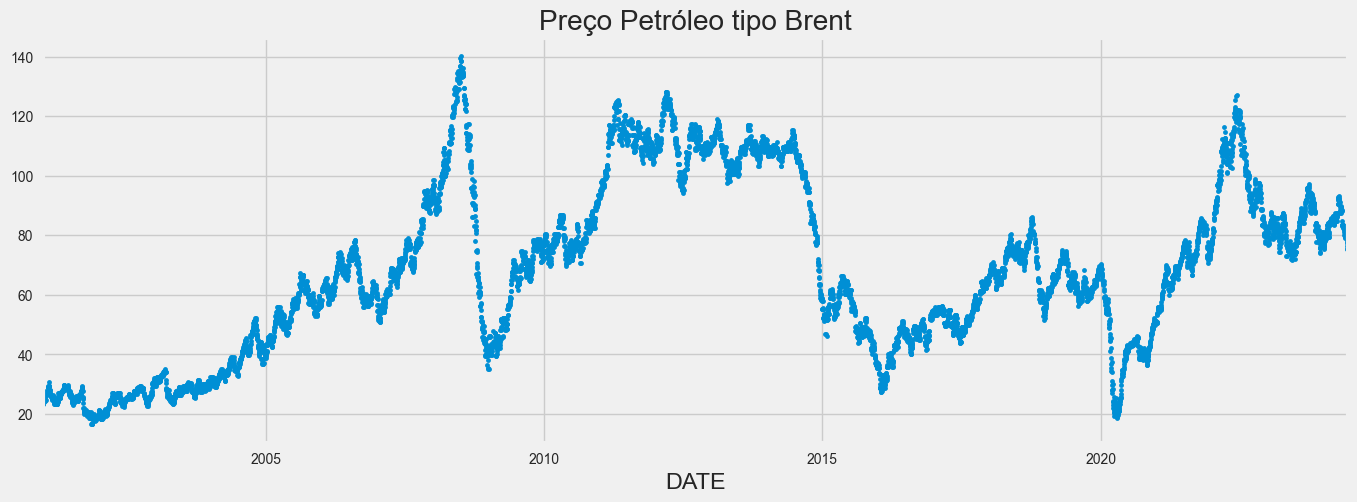

In [62]:
# df.plot(style='.', figsize=(15,5), color=color_pal[0], title = "PJME Energy Use in Mega walt (MW)");
data["VALUE (US$)"].plot(
    style=".", figsize=(15, 5), color=color_pal[0], title="Preço Petróleo tipo Brent"
)


In [63]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.day_of_year
    return df


df = create_features(data)


In [64]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8562 entries, 2001-01-01 to 2024-06-10
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   VALUE (US$)  8562 non-null   float64
 1   hour         8562 non-null   int32  
 2   dayofweek    8562 non-null   int32  
 3   quarter      8562 non-null   int32  
 4   month        8562 non-null   int32  
 5   year         8562 non-null   int32  
 6   dayofyear    8562 non-null   int32  
dtypes: float64(1), int32(6)
memory usage: 334.5 KB


In [65]:
# df.drop(["DAY", "MONTH", "YEAR"], axis=1, inplace=True)
df.head()


VALUE (US$)  hour  dayofweek  quarter  month  year  dayofyear
DATE                                                                     
2001-01-01        23.43     0          0        1      1  2001          1
2001-01-02        23.43     0          1        1      1  2001          2
2001-01-03        23.44     0          2        1      1  2001          3
2001-01-04        24.57     0          3        1      1  2001          4
2001-01-05        24.77     0          4        1      1  2001          5

In [66]:
df = df.loc["2018-01-01":]
fh = int(len(df) * 0.10)


# Experimento com o modelo univariado

In [67]:
df_uni = df["VALUE (US$)"]


In [68]:
experiment_uni = TSForecastingExperiment()
experiment_uni.setup(
    data=df_uni,
    target="VALUE (US$)",
    fh=fh,
    fold=5,
    use_gpu=True,
    scale_target="minmax",
    session_id=42,
)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with

In [69]:
experiment_uni.plot_model()


In [70]:
experiment_uni.plot_model(data_kwargs={"plot_data_type": ["transformed"]})


In [71]:
experiment_uni.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})


In [72]:
experiment_uni.plot_model(
    plot="diff",
    data_kwargs={
        "lags_list": [[1], [1, 16]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    fig_kwargs={"height": 800, "width": 1500},
)


In [73]:
experiment_uni.plot_model(
    plot="train_test_split", fig_kwargs={"height": 400, "width": 900}
)


In [74]:
experiment_uni.plot_model(plot="decomp_stl", fig_kwargs={"height": 400, "width": 900})


In [75]:
experiment_uni.check_stats()


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting          Value  
0                                    2353.0  
1                                       0.0  
2                                  0.498066  
3                                  0.506693  
4                                  0.177858  
5                                  0.031634  
6                                  0.480579  
7                                 -0.142188  
8                                    1975.0  
9   {'alpha': 0.05, 'K': 24}   53847.813509  
10  {'alpha': 0.05, 'K': 48}  100855.448095  
11  {'alpha': 0.05, 'K': 24}            0.0  
12  {'alpha': 0.05, 'K': 48}            0.0  
13  {'alpha': 0.05, 'K': 24}            0.0  
14  {'alpha': 0.05, 'K': 48}            0.0  
15           {'alpha': 0.05}          False  
16           {'alpha': 0.05}       0.465991  
17           {'alpha': 0.05}      -1.632866  
18           {'alpha': 0.05}       -3.43315  
19           {'alpha': 0.05}      -2.862777  
20           {'alpha': 0.05}      -2.567429  
21           {'alpha': 0.05}          False  
22           {'alpha': 0.05}           0.01  
23           {'alpha': 0.05}       0.766021  
24           {'alpha': 0.05}          0.119  
25           {'alpha': 0.05}          0.146  
26           {'alpha': 0.05}          0.176  
27           {'alpha': 0.05}          0.216  
28           {'alpha': 0.05}          False  
29           {'alpha': 0.05}            0.0

In [76]:
experiment_uni.models()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1


Name  \
ID                                                                   
naive                                             Naive Forecaster   
grand_means                                 Grand Means Forecaster   
snaive                                   Seasonal Naive Forecaster   
polytrend                              Polynomial Trend Forecaster   
arima                                                        ARIMA   
auto_arima                                              Auto ARIMA   
exp_smooth                                   Exponential Smoothing   
ets                                                            ETS   
theta                                             Theta Forecaster   
stlf                                                          STLF   
croston                                                    Croston   
bats                                                          BATS   
tbats                                                        TBATS   
prophet                                                    Prophet   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending   
llar_cds_dt      Lasso Least Angular Regressor w/ Cond. Deseaso...   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending   
et_cds_dt          Extra Trees w/ Cond. Deseasonalize & Detrending   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending   
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...   

                                                         Reference  Turbo  
ID                                                                         
naive                     sktime.forecasting.naive.NaiveForecaster   True  
grand_means               sktime.forecasting.naive.NaiveForecaster   True  
snaive                    sktime.forecasting.naive.NaiveForecaster   True  
polytrend        sktime.forecasting.trend._polynomial_trend_for...   True  
arima                               sktime.forecasting.arima.ARIMA   True  
auto_arima                      sktime.forecasting.arima.AutoARIMA   True  
exp_smooth       sktime.forecasting.exp_smoothing.ExponentialSm...   True  
ets                                 sktime.forecasting.ets.AutoETS   True  
theta                     sktime.forecasting.theta.ThetaForecaster   True  
stlf             sktime.forecasting.trend._stl_forecaster.STLFo...   True  
croston                         sktime.forecasting.croston.Croston   True  
bats                                  sktime.forecasting.bats.BATS  False  
tbats                               sktime.forecasting.tbats.TBATS  False  
prophet          pycaret.containers.models.time_series.ProphetP...  False  
lr_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
en_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
ridge_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
lasso_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
llar_cds_dt      pycaret.containers.models.time_series.BaseCdsD...   True  
br_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
huber_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
omp_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True

In [77]:
include = [
    "ridge_cds_dt",
    "arima",
    "huber_cds_dt",
    "lightgbm_cds_dt",
    "knn_cds_dt",
    "gbr_cds_dt",
    "br_cds_dt",
    "dt_cds_dt",
    "rf_cds_dt",
    "ada_cds_dt",
    "omp_cds_dt",
    "ets",
    "en_cds_dt",
    "huber_cds_dt",
    "lr_cds_dt",
    "lasso_cds_dt",
    "polytrend",
    "xgboost_cds_dt",
]
exclude = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt", "huber_cds_dt"]


In [78]:
metric = "mape"
best = experiment_uni.compare_models(
    n_select=5,
    include=include,
    # exclude=exclude,
    sort=metric,
    turbo=True,
)


KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

In [79]:
compare_metrics = experiment_uni.pull()


In [80]:
compare_metrics


Model    MASE  \
ets                                                            ETS  5.7027   
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...  5.6593   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending    5.82   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending  5.8017   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...  6.2084   
arima                                                        ARIMA    6.61   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...  6.8428   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending  7.0433   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending  7.1726   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...  7.1625   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending  7.1642   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending  7.0921   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...  7.2737   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending  7.3533   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending  7.3533   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending  9.9232   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending  9.9232   
polytrend                              Polynomial Trend Forecaster  9.9311   

                  RMSSE      MAE     RMSE    MAPE   SMAPE      R2  TT (Sec)  
ets              5.0409  12.7403  14.5269  0.1532  0.1543 -1.9774     0.088  
xgboost_cds_dt   5.2867  12.6423  15.2235  0.1533   0.163 -1.6394     1.460  
ada_cds_dt       5.4432  12.9932  15.6706  0.1579  0.1685 -1.8675     1.632  
rf_cds_dt        5.3907  12.9535  15.5198   0.158  0.1685 -1.9178     4.738  
gbr_cds_dt       5.7169  13.8724  16.4702  0.1692  0.1803 -2.3538     1.490  
arima             5.953  14.7613  17.1558  0.1815  0.1932 -3.2512     0.104  
omp_cds_dt       6.2432  15.1747  17.8509   0.185  0.2076 -3.8025     1.254  
knn_cds_dt       6.3927   15.827   18.528  0.1922  0.1977  -3.347     4.668  
ridge_cds_dt     6.5159  15.9767  18.7127  0.1934  0.2098 -3.9023     1.358  
br_cds_dt        6.4907  15.9497  18.6383  0.1941  0.2113 -4.0175     1.364  
lr_cds_dt        6.4918  15.9534  18.6414  0.1941  0.2114 -4.0215     1.250  
dt_cds_dt        6.8418  15.9836  19.9347   0.195  0.2091 -3.9342     1.260  
lightgbm_cds_dt  6.5615  16.3055  18.9659  0.1961  0.2011 -3.7801     1.494  
huber_cds_dt     6.5864  16.5004  19.0773   0.201  0.2035 -4.4234     1.528  
huber_cds_dt     6.5864  16.5004  19.0773   0.201  0.2035 -4.4234     1.462  
en_cds_dt        8.6205  21.8122  24.4867  0.2591  0.3235 -8.4372     1.318  
lasso_cds_dt     8.6205  21.8122  24.4867  0.2591  0.3235 -8.4372     1.318  
polytrend        8.6277  21.8301  24.5079  0.2594  0.3239 -8.4594     0.018

In [81]:
compare_metrics.to_csv("compare_metrics_uni.csv")


In [82]:
experiment_uni.plot_model(best, plot="forecast")


In [ ]:
# tunning
best_tuned_models = [experiment_uni.tune_model(model) for model in best]


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.8s finished


Initiated  . . . . . . . . . . . . . . . . . .               22:39:35
Status     . . . . . . . . . . . . . . . . . .        Fitting 5 Folds
Estimator  . . . . . . . . . . . . . . . . . .  DecisionTreeRegressor

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.5s finished


KeyboardInterrupt: 

In [ ]:
compare_metrics = experiment_uni.pull()


In [ ]:
compare_metrics


cutoff    MASE   RMSSE      MAE     RMSE    MAPE   SMAPE       R2
0     2019-08-16  2.1665  2.3489   9.0828  12.2732  0.3087  0.2221   0.4337
1     2020-08-02  7.1866  6.3775  35.5238  44.4942  0.5534  0.9257 -11.9302
2     2021-07-20  3.6876  3.3319  16.7881  21.1279  0.1614  0.1817  -0.2907
3     2022-07-07  9.8845  8.0747  51.5833  57.4018  0.6314  0.4525 -30.1481
Mean         NaT  5.7313  5.0332  28.2445  33.8243  0.4137  0.4455 -10.4838
SD           NaT  3.0105  2.2999  16.5538  17.9958  0.1881  0.2959  12.3680

In [ ]:
# Get model weights to use
top_model_metrics = compare_metrics.iloc[0:5][metric.upper()]
display(top_model_metrics)

top_model_weights = 1 - top_model_metrics / top_model_metrics.sum()
display(top_model_weights)


0       0.3087
1       0.5534
2       0.1614
3       0.6314
Mean    0.4137
SD      0.1881
Name: MAPE, dtype: float64

0       0.863207
1       0.754775
2       0.928480
3       0.720211
Mean    0.816679
SD      0.916648
Name: MAPE, dtype: float64

In [ ]:
best_tuned_models.__len__()


8

In [ ]:
blender = experiment_uni.blend_models(
    best_tuned_models,
    method="mean",
    optimize="MAPE",
    # weights=top_model_weights.values.tolist(),
)


In [ ]:
y_predict = experiment_uni.predict_model(blender)
y_predict


y_pred
2023-06-25  74.2983
2023-06-26  74.5763
2023-06-27  74.8632
2023-06-28  75.1346
2023-06-29  75.1030
...             ...
2024-06-06  85.4044
2024-06-07  85.4557
2024-06-08  85.0652
2024-06-09  85.1922
2024-06-10  85.3076

[352 rows x 1 columns]

In [ ]:
experiment_uni.plot_model(estimator=blender)


In [ ]:
final_model = experiment_uni.finalize_model(blender)
print(experiment_uni.predict_model(final_model, fh=90))
experiment_uni.plot_model(final_model)


             y_pred
2024-06-11  79.8139
2024-06-12  80.2686
2024-06-13  80.3813
2024-06-14  80.5445
2024-06-15  80.3341
...             ...
2024-09-04  82.9046
2024-09-05  83.0335
2024-09-06  83.2039
2024-09-07  83.3982
2024-09-08  83.4980

[90 rows x 1 columns]


In [ ]:
_ = experiment_uni.save_model(final_model, "petr_blender_model_uni")


Transformation Pipeline and Model Successfully Saved


In [ ]:
# Load saved model
loaded_exp = TSForecastingExperiment()
m = loaded_exp.load_model("petr_blender_model_uni")
# m = loaded_exp.load_experiment("petr_blender_model", preprocess_data = False)
# Predictions should be same as before the model was saved and loaded
# loaded_exp.setup(scale_target='maxabs'
loaded_data = loaded_exp.predict_model(m)


Transformation Pipeline and Model Successfully Loaded


In [ ]:
loaded_data


y_pred
2024-05-14  83.7443
2024-05-15  83.7011
2024-05-16  83.7154
2024-05-17  83.7644
2024-05-18  83.7893
...             ...
2024-12-27  87.5670
2024-12-28  87.6103
2024-12-29  87.7039
2024-12-30  87.5600
2024-12-31  87.6089

[232 rows x 1 columns]

In [ ]:
loaded_exp.setup(data=loaded_data, use_gpu=True)
loaded_exp.plot_model(data_kwargs={"plot_data_type": ["transformed"]})


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with